In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import re

In [ ]:
df = pd.read_csv('./VN_housing_dataset.csv', index_col= 0)
df.head(5)

,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0.0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²"
1.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²"
2.0,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²
3.0,2020-08-05,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6 phòng,51 m²,12.75 m,4 m,100 triệu/m²
4.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4 phòng,36 m²,9 m,4 m,"86,11 triệu/m²"


In [4]:
df_renamed = df.rename(columns = {"Ngày":"date", "Địa chỉ":"address", "Quận":"district", 
                                  "Huyện":"ward", "Loại hình nhà ở":"type_of_housing",
                                 "Giấy tờ pháp lý":"legal_paper", "Số tầng":"num_floors",
                                 "Số phòng ngủ":"num_bed_rooms", "Diện tích":"squared_meter_area",
                                 "Dài":"length_meter", "Rộng":"width_meter", "Giá/m2":"price_in_million_per_square_meter"})




# Filter data
# Remove houses with "10 plus" floors and bed rooms, since this cannot be exactly quantified
df_renamed = df_renamed[df_renamed['num_floors'] != 'Nhiều hơn 10']
df_renamed = df_renamed[df_renamed['num_bed_rooms'] != 'nhiều hơn 10 phòng']
df_renamed['date'] = pd.to_datetime(df_renamed['date'], errors='coerce')
# Clean columns and convert numerical columns to float type
    # Add more features ( if needed)

df_renamed['year'] = df_renamed['date'].dt.year
df_renamed['month'] = df_renamed['date'].dt.month
df_renamed['day_of_week'] = df_renamed['date'].dt.dayofweek
df_renamed['is_weekend'] = df_renamed['date'].dt.weekday >= 5

df_renamed['address'] = df_renamed['address'].fillna("UNK")
df_renamed['street'] = df_renamed['address'].str.split(',').apply(lambda x: x[0].strip())

df_renamed['district'] = df_renamed['district'].str.replace('Quận ','').str.strip()
df_renamed['ward'] = df_renamed['ward'].str.replace('Phường ','').str.strip()
df_renamed['num_floors'] = df_renamed['num_floors'].str.strip().astype(float)
df_renamed['num_bed_rooms'] = df_renamed['num_bed_rooms'].str.replace(' phòng','').str.strip().astype(float)
df_renamed['squared_meter_area'] = df_renamed['squared_meter_area'].str.replace(' m²','').str.strip().astype(float)
df_renamed['length_meter'] = df_renamed['length_meter'].str.replace(' m','').str.strip().astype(float)
df_renamed['width_meter'] = df_renamed['width_meter'].str.replace(' m','').str.strip().astype(float)



cat_col = ['address', 'street','district', 'ward', 'type_of_housing', 'legal_paper']
num_col = [col for col in df_renamed.columns if col not in cat_col]

df_renamed[cat_col] = df_renamed[cat_col].fillna("UNK")
df_renamed[num_col] = df_renamed[num_col].fillna(-1)



# Clean and convert all prices to million/m2 instead of VND/m2 or billion/m2
        # Convert values containing 'tỷ/m²'
df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' tỷ/m²', na=False), 'price_in_million_per_square_meter'] = \
    df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' tỷ/m²', na=False), 'price_in_million_per_square_meter'] \
    .str.replace(' tỷ/m²', '').str.replace('.', '').str.replace(',', '.').astype(float) * 1000

        # Convert values containing 'triệu/m²'
df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' triệu/m²', na=False), 'price_in_million_per_square_meter'] = \
    df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' triệu/m²', na=False), 'price_in_million_per_square_meter'] \
    .str.replace(' triệu/m²', '').str.replace(',', '.').astype(float)

        # Convert values containing 'đ/m²'
df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' đ/m²', na=False), 'price_in_million_per_square_meter'] = \
    df_renamed.loc[df_renamed['price_in_million_per_square_meter'].str.contains(' đ/m²', na=False), 'price_in_million_per_square_meter'] \
    .str.replace(' đ/m²', '').str.replace('.', '').astype(float) * 0.000001
df_renamed['price_in_million_per_square_meter'] = df_renamed['price_in_million_per_square_meter'].astype(float)
# Add informative features
# Total number of rooms (sum of floors and bedrooms)
df_renamed['total_rooms'] = df_renamed['num_floors'] + df_renamed['num_bed_rooms']

# Floors per Bedroom (ratio of number of floors to number of bedrooms)
df_renamed['floors_per_bedroom'] = df_renamed['num_floors'] / df_renamed['num_bed_rooms']


# Remove redundant columns
df_renamed = df_renamed.drop(columns= ['address', 'date'])



In [5]:
df_renamed.head(1)

,district,ward,type_of_housing,legal_paper,num_floors,num_bed_rooms,squared_meter_area,length_meter,width_meter,price_in_million_per_square_meter,year,month,day_of_week,is_weekend,street,total_rooms,floors_per_bedroom
0.0,Cầu Giấy,Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4.0,5.0,46.0,-1.0,-1.0,86.96,2020.0,8.0,2.0,False,Đường Hoàng Quốc Việt,9.0,0.8


In [6]:
df_renamed.info()   

<class 'pandas.core.frame.DataFrame'>
Index: 81627 entries, 0.0 to nan
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   district                           81627 non-null  object 
 1   ward                               81627 non-null  object 
 2   type_of_housing                    81627 non-null  object 
 3   legal_paper                        81627 non-null  object 
 4   num_floors                         81627 non-null  float64
 5   num_bed_rooms                      81627 non-null  float64
 6   squared_meter_area                 81627 non-null  float64
 7   length_meter                       81627 non-null  float64
 8   width_meter                        81627 non-null  float64
 9   price_in_million_per_square_meter  81627 non-null  float64
 10  year                               81627 non-null  float64
 11  month                              81627 non-null  float64


# EDA PART

In [7]:
# Setting up plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Descriptive Statistics
numeric_summary = df_renamed.describe()
categorical_columns = df_renamed.select_dtypes(include='object').columns
df_renamed[categorical_columns].describe()



,district,ward,type_of_housing,legal_paper,street
count,81627,81627,81627,81627,81627
unique,30,309,5,4,6302
top,Đống Đa,Khương Trung,"Nhà ngõ, hẻm",Đã có sổ,Đường Minh Khai
freq,13822,2820,62125,52338,1647


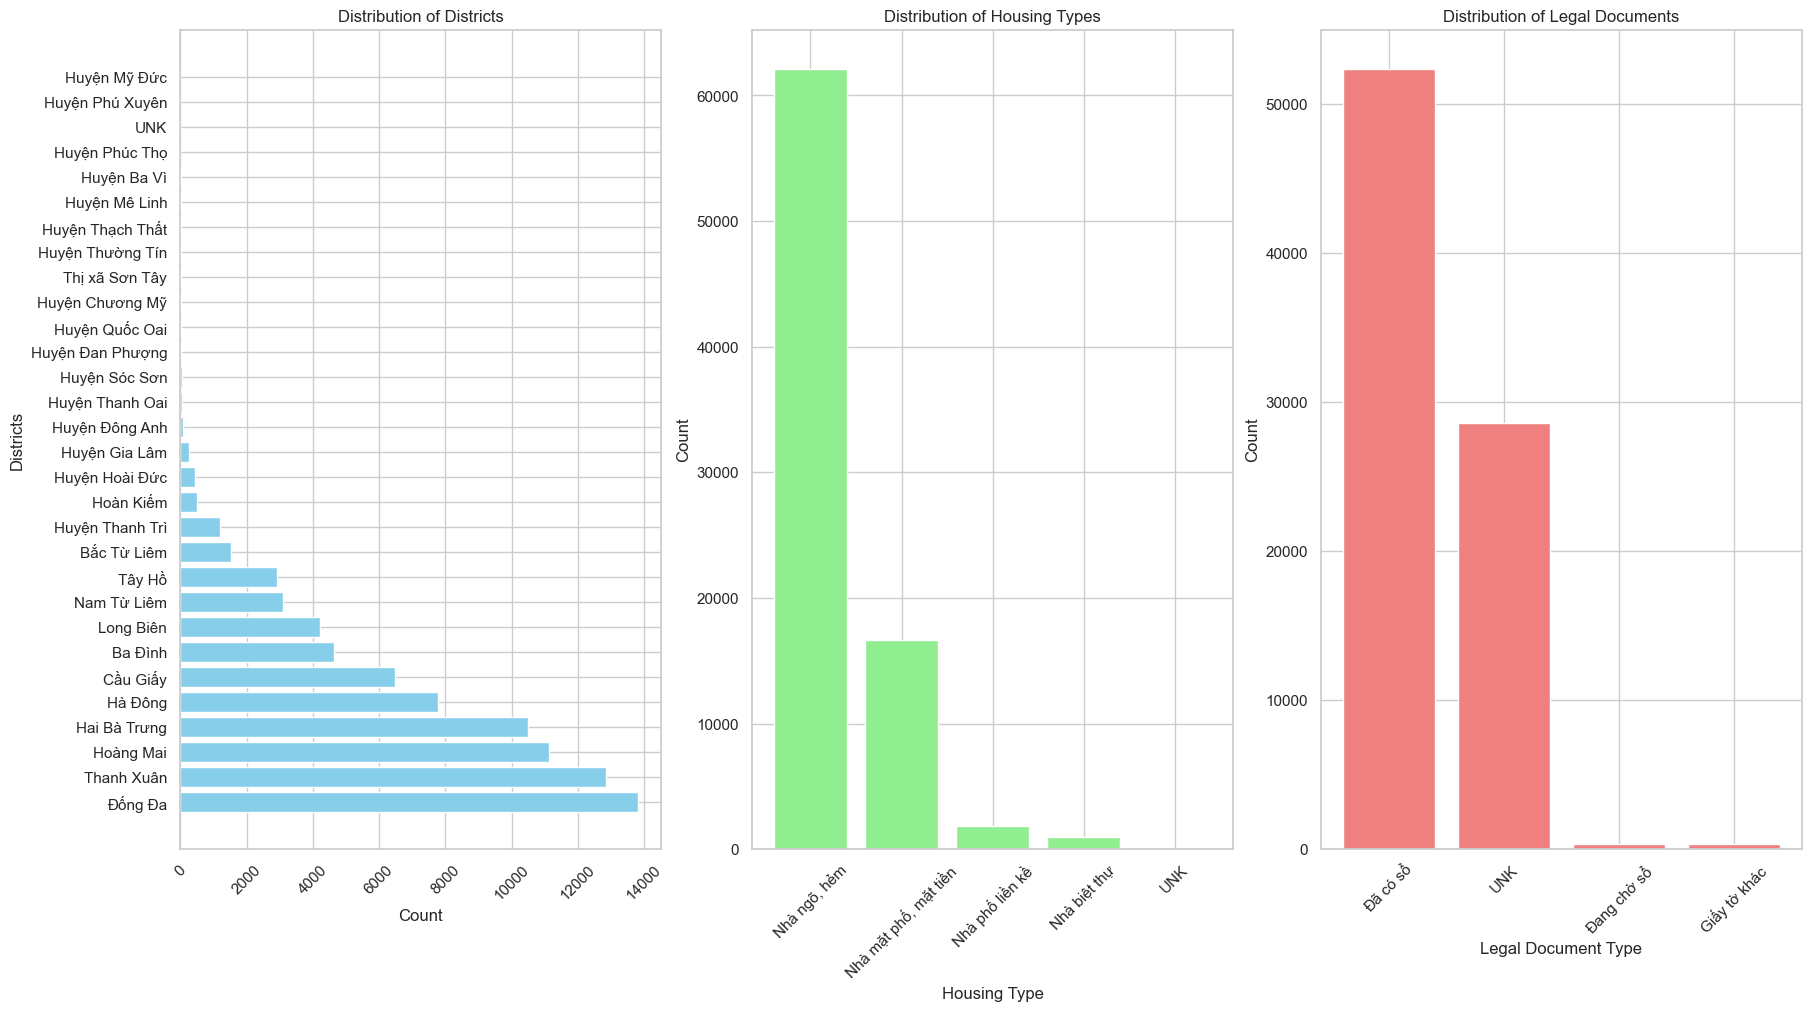

In [12]:
# 2. Distribution of categorical variables
district_distribution = df_renamed['district'].value_counts()
housing_type_distribution = df_renamed['type_of_housing'].value_counts()
legal_docs_distribution = df_renamed['legal_paper'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(18, 10), constrained_layout=True)

# Distribution of districts
axes[0].barh(district_distribution.index, district_distribution.values, color='skyblue')
axes[0].set_title('Distribution of Districts')
axes[0].set_ylabel('Districts')
axes[0].set_xlabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Distribution of housing types
axes[1].bar(housing_type_distribution.index, housing_type_distribution.values, color='lightgreen')
axes[1].set_title('Distribution of Housing Types')
axes[1].set_xlabel('Housing Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Distribution of legal documents
axes[2].bar(legal_docs_distribution.index, legal_docs_distribution.values, color='lightcoral')
axes[2].set_title('Distribution of Legal Documents')
axes[2].set_xlabel('Legal Document Type')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

# Show the plots
plt.show()


d:\EnV\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\EnV\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


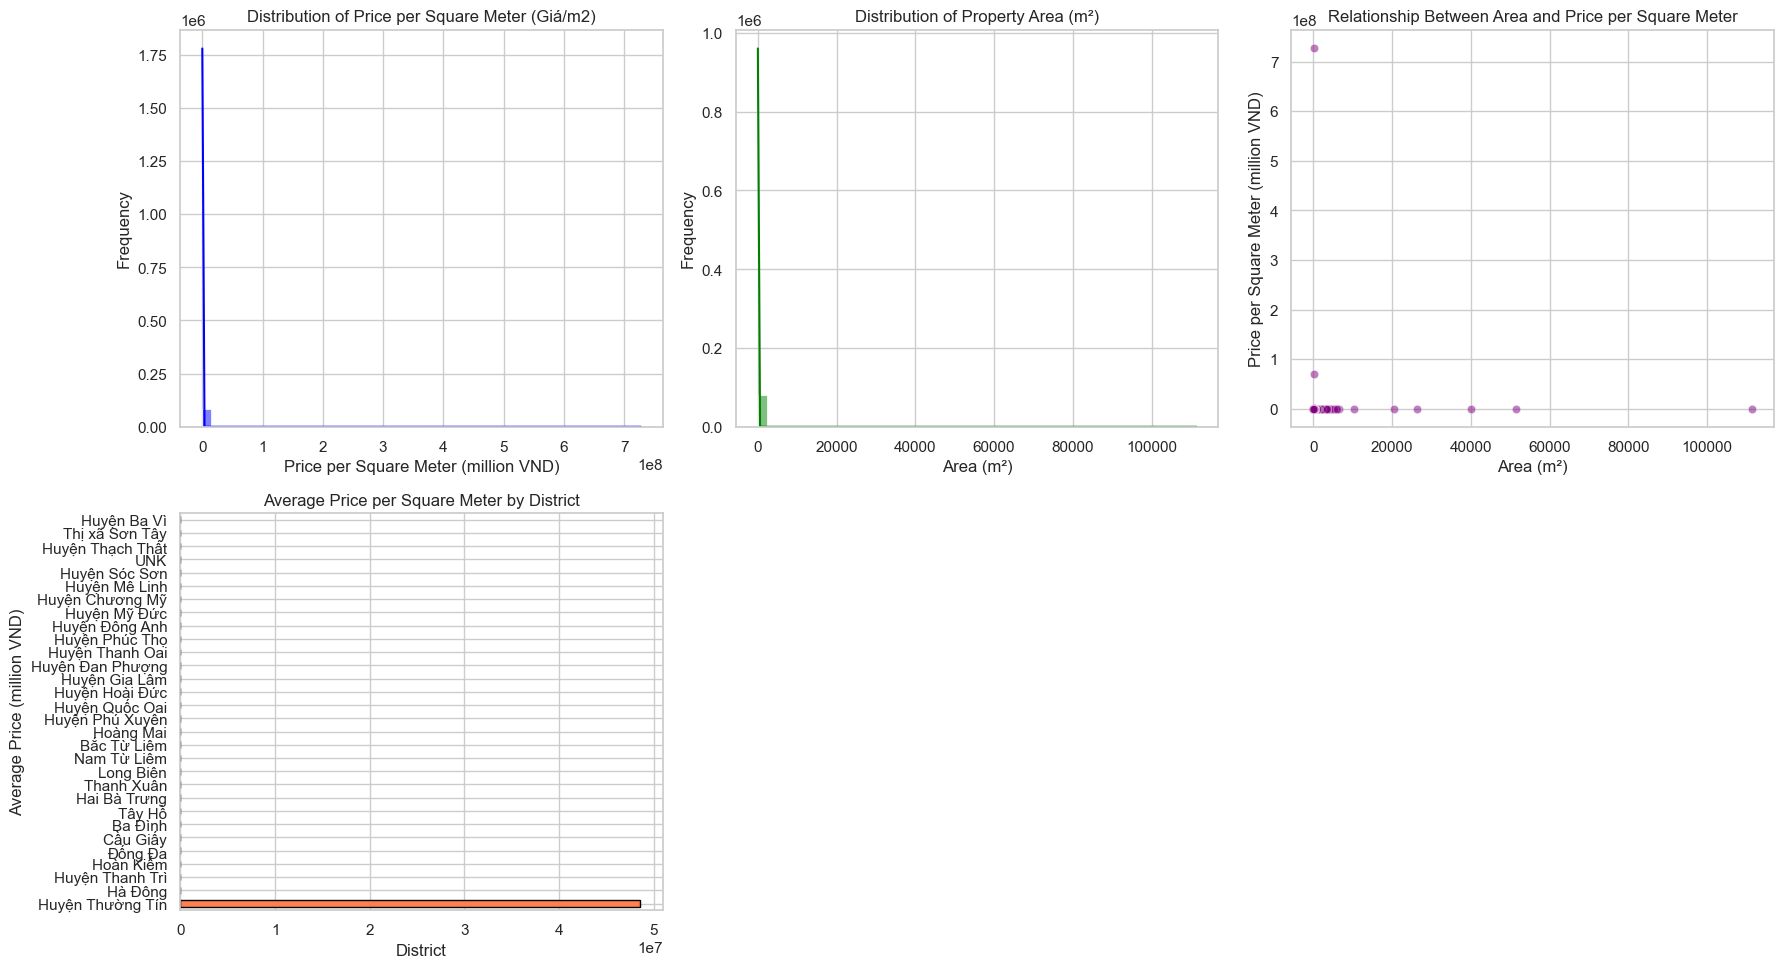

In [23]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 3. Price Distribution
sns.histplot(df_renamed['price_in_million_per_square_meter'], bins=50, kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Price per Square Meter (Giá/m2)')
axes[0, 0].set_xlabel('Price per Square Meter (million VND)')
axes[0, 0].set_ylabel('Frequency')

# 4. Area Distribution
sns.histplot(df_renamed['squared_meter_area'], bins=50, kde=True, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Property Area (m²)')
axes[0, 1].set_xlabel('Area (m²)')
axes[0, 1].set_ylabel('Frequency')

# 5. Relationship Between Area and Price
sns.scatterplot(x=df_renamed['squared_meter_area'], y=df_renamed['price_in_million_per_square_meter'], alpha=0.5, color='purple', ax=axes[0, 2])
axes[0, 2].set_title('Relationship Between Area and Price per Square Meter')
axes[0, 2].set_xlabel('Area (m²)')
axes[0, 2].set_ylabel('Price per Square Meter (million VND)')

# 6. Average Price by District
district_avg_price = df_renamed.groupby('district')['price_in_million_per_square_meter'].mean().sort_values(ascending=False)
district_avg_price.plot(kind='barh', color='coral', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_title('Average Price per Square Meter by District')
axes[1, 0].set_xlabel('District')
axes[1, 0].set_ylabel('Average Price (million VND)')

axes[1, 1].axis('off')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# data có quá nhiều outliers dẫn dến distribution qúa lệch -> nên xử lí outliers

Text(0.5, 1.0, 'Correlation Heatmap')

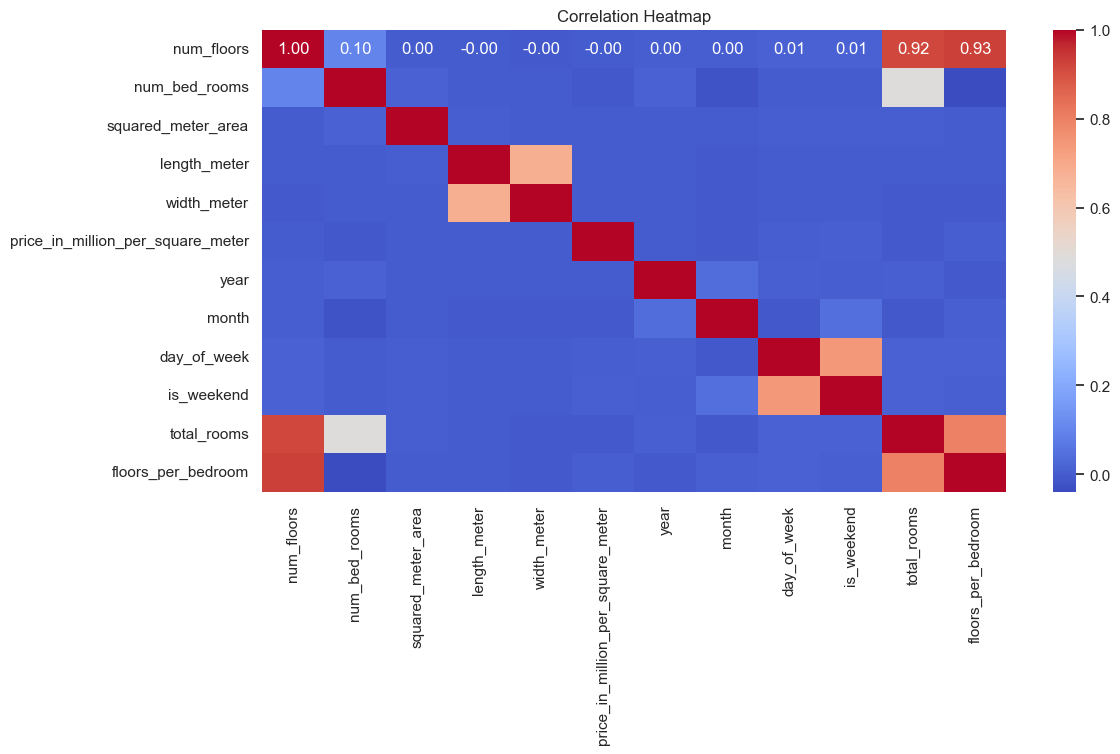

In [21]:
# 7. Correlation Heatmap
correlation_matrix = df_renamed[[col for col in df_renamed.columns if col not in categorical_columns]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')